In [2]:
# See https://astropy-tutorials.readthedocs.io/en/latest/rst-tutorials/FITS-images.html
# and https://astropy-tutorials.readthedocs.io/en/latest/rst-tutorials/FITS-header.html
# and https://pcjericks.github.io/py-gdalogr-cookbook/raster_layers.html

import numpy as np

# Set up matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.io import fits
from astropy import wcs
from astropy import units as u
from astropy.nddata import Cutout2D
from osgeo import gdal

HiRISE mosaic converted to FITS using ISIS (too big for gdal_translate)
std2isis (from JPEG2000 to .cub) then isis2fits (from .cub to FITS)
The 32bit float flipped FITS has been converted as a numpy array in 16bit signed integer standard FITS
WCS information has been extracted from the PDS label description

In [12]:
image_file = "ESP_056284_0935_RED.proj.fits"

Open the image with astropy

In [13]:
hdu_list = fits.open(image_file)
hdu_list.info()

Filename: ESP_056284_0935_RED.proj.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      28   (54025, 53882)   int16 (rescales to float32)   


How to extract basic information from the FITS header with astropy 

In [4]:
head = hdu_list[0].header
print('Offset = ', head['BZERO'])
print('Scale = ', head['BSCALE'])
print('NoDataValue = ', head['BLANK'])
print('MinValidValue = ', head['DATAMIN'])
print('MaxValidValue = ', head['DATAMAX'])

Offset =  0.073541745610404
Scale =  9.72662858695943e-05
NoDataValue =  0
MinValidValue =  3
MaxValidValue =  1021


Open the image with gdal

In [14]:
src_ds = gdal.Open(image_file)
print('Raster Band Count : ', src_ds.RasterCount)

Raster Band Count :  1


How to extract basic information from the FITS header with gdal

In [16]:
srcband = src_ds.GetRasterBand(1)
print('Offset = ', srcband.GetOffset())
print('Scale = ', srcband.GetScale())
print('NoDataValue = ', srcband.GetNoDataValue())

Offset =  0.073541745610404
Scale =  9.72662858695943e-05
NoDataValue =  0.0


How to extract geospatial information from the FITS header with astropy

In [17]:
w = wcs.WCS(image_file)
print(w)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'MALN-STG'  'MALT-STG'  
CRVAL : 0.0  -90.0  
CRPIX : 890624.5  -29622.5  
CD1_1 CD1_2  : 0.0  4.243e-06  
CD2_1 CD2_2  : -4.243e-06  0.0  
NAXIS : 54025  53882


In [9]:
lon, lat = w.all_pix2world(27018.3, 26948.6, 1)
print('{0:10.6f} {1:10.6f}'.format(lon, lat))

  3.747844 -86.329122


In [10]:
px, py = w.all_world2pix(lon, lat, 1)
print('{0:6.4f} {1:6.4f}'.format(px, py))

27018.3000 26948.6000


In [11]:
array_lon, array_lat = w.all_pix2world([0.5, 0.5+54025/2., 54025.5], [0.5, 0.5 + 53882/2., 53882.5], 1)
print(array_lon, array_lat)

[1.90500975 3.74735174 5.70008941] [-86.22036389 -86.32910137 -86.43382321]


In [28]:
image_data = hdu_list[0].data

<class 'numpy.ndarray'>
(4714, 4714)
float32
Min: 0.074806206
Max: 0.17304516
Mean: 0.11007556
Stdev: 0.003626854


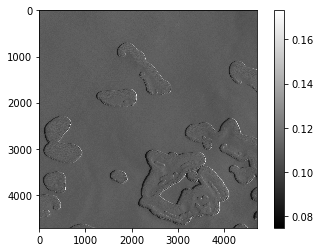

In [35]:
position = (0.5+54025/2.,0.5 + 53882/2.)
size = u.Quantity((0.02, 0.02), u.deg)
cutout = Cutout2D(image_data, position, size, wcs=w)
crop_data = cutout.data
print(type(crop_data))
print(crop_data.shape)
print(crop_data.dtype.name)
plt.imshow(crop_data, cmap='gray')
plt.colorbar()
print('Min:', np.min(crop_data))
print('Max:', np.max(crop_data))
print('Mean:', np.mean(crop_data))
print('Stdev:', np.std(crop_data))

In [36]:
outfile = 'hirisecropped.fits'

hdu = fits.PrimaryHDU(crop_data)
hdu.header = head
hdu.header.update(cutout.wcs.to_header())

hdu.writeto(outfile, overwrite=True)

In [37]:
hdu_list.close()